In [78]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [79]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor


In [80]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [81]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [82]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [83]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4], device='mps:0')


In [84]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0165,  0.0091,  0.0106,  ...,  0.0139,  0.0079,  0.0022],
        [-0.0282, -0.0333, -0.0157,  ...,  0.0269, -0.0032, -0.0354]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0165, -0.0327], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0089,  0.0088, -0.0029,  ..., -0.0346, -0.0100, -0.0404],
        [ 0.0304,  0.0104,  0.0353,  ..., -0.0414, -0.0412, -0.0169]],
       device='mps:0', grad_fn=<Slice

In [85]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

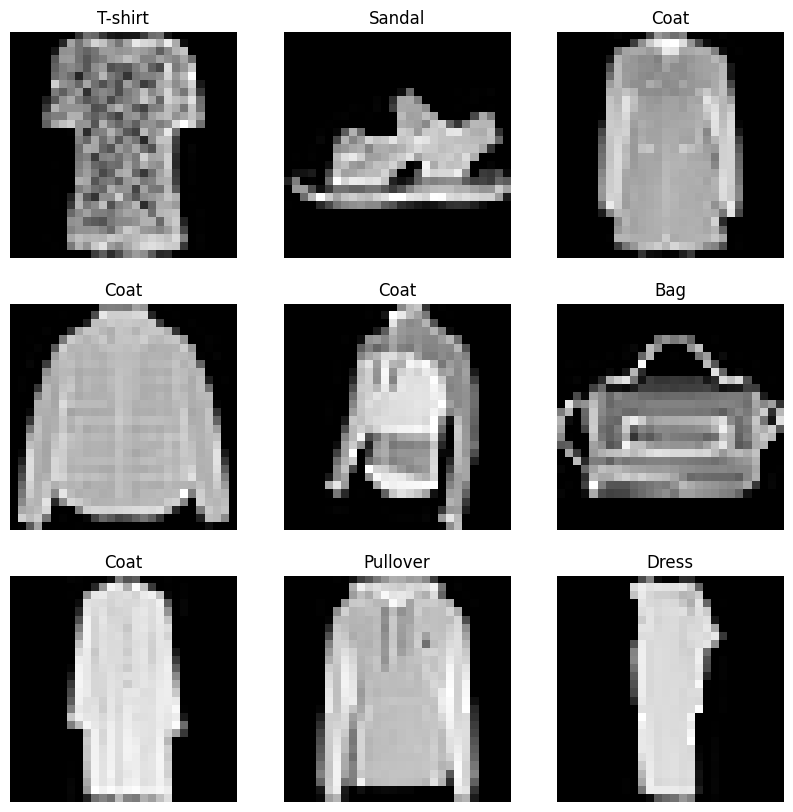

In [86]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x323807ab0>


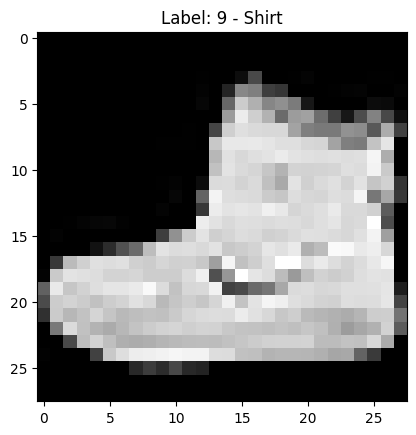

Labels batch shape: torch.Size([64])


In [87]:
# Define hyperparameter
batch_size = 64

# Create data loaders
train_dl= DataLoader(train_data, batch_size = batch_size)
test_dl = DataLoader(test_data, batch_size=batch_size)

for X,y in train_dl:
    train_features, train_labels = next(iter(train_dl))
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0]
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.size()}")
    break


In [88]:
# Define hyperparameters
learning_rate = 1e-3
epochs = 5

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [89]:
def trainloop (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')


In [90]:
def evaluate (dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [91]:
for i in range(50):
    print(f"Epoch {i+1}\n-------------------------------")
    trainloop(train_dl, model, loss_fn, optimizer)
    evaluate(test_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:2.318224 [    0/60000]
loss:2.297930 [ 6400/60000]
loss:2.282003 [12800/60000]
loss:2.272173 [19200/60000]
loss:2.260046 [25600/60000]
loss:2.229113 [32000/60000]
loss:2.238392 [38400/60000]
loss:2.205570 [44800/60000]
loss:2.207971 [51200/60000]
loss:2.175187 [57600/60000]
Test Error: 
 Accuracy: 39.8%, Avg loss: 2.174078 

Epoch 2
-------------------------------
loss:2.192715 [    0/60000]
loss:2.177279 [ 6400/60000]
loss:2.129233 [12800/60000]
loss:2.140798 [19200/60000]
loss:2.099585 [25600/60000]
loss:2.038772 [32000/60000]
loss:2.069542 [38400/60000]
loss:1.989747 [44800/60000]
loss:1.998392 [51200/60000]
loss:1.941942 [57600/60000]
Test Error: 
 Accuracy: 53.0%, Avg loss: 1.934310 

Epoch 3
-------------------------------
loss:1.971660 [    0/60000]
loss:1.938957 [ 6400/60000]
loss:1.832319 [12800/60000]
loss:1.869156 [19200/60000]
loss:1.772760 [25600/60000]
loss:1.708638 [32000/60000]
loss:1.742874 [38400/60000]
loss:1.628628 [44800

In [101]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
x = x.to(device)

with torch.no_grad():
    pred = model(x)
    pred_y= torch.randint((pred[0].argmax(0)), size = (1,)).item()
    y= torch.randint(y, size = (1,)).item()
    predicted, actual = labels_map[pred_y], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Shirt", Actual: "Dress"
